In [1]:
# Imports

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

import tigramite
from tigramite.data_processing import DataFrame
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr

In [2]:
from astropy.visualization import astropy_mpl_style
astropy_mpl_style['axes.grid'] = False
plt.style.use(astropy_mpl_style)

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits

In [3]:
# Normalization with sca
def stand_sca(data):
    new_data=(data-data.mean())/data.std()
    return new_data

In [18]:
#读入数据为dataframe格式，并做0均值1标准差处理
df_result = pd.read_excel(r'Humboldt-FAO.xlsx')
df_result = df_result.drop(columns=['year','region-FAO'])
df_result1 = stand_sca(df_result)
df_result1.head()

,A.landing-sum,S.landing-sum,temp,sea_level
0,-1.407332,-0.632552,-0.400094,-1.074254
1,-1.401571,-0.632442,1.572729,-1.026329
2,-1.399784,-0.631024,-0.860731,-0.996376
3,-1.393943,-0.630101,-1.622844,-0.992097
4,-1.376953,-0.631905,-0.152031,-0.970702


In [12]:
# raw values from csv 
dataset1 = df_result1.to_numpy()

# variable names
var_names = [r'$A.landing$', r'$S.landing$', r'$temp$',  r'$slr$']

# generate the dataframe
dataframe_y = DataFrame({1: dataset1}, analysis_mode='single', var_names=var_names)

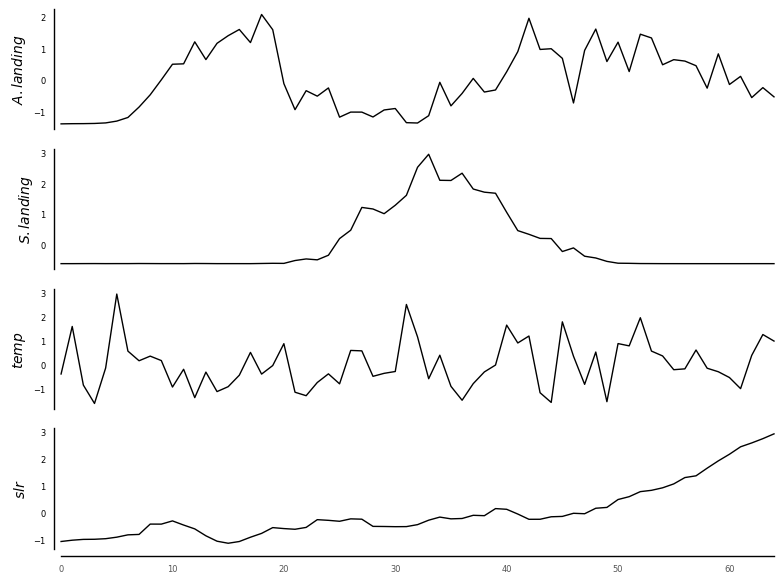

<Figure size 200x100 with 0 Axes>

In [13]:
for member in dataframe_y.values.keys():
    tp.plot_timeseries(selected_dataset = member, dataframe = dataframe_y)
    plt.figure(figsize=(2,1))
    plt.show()

In [22]:
#生成切片
def Generate(dataframe, step, cliplen):
    
    #序列总长度
    Len = len(dataframe)
    #切片数量
    num = (Len - cliplen) // step + 1
    
    dfs = []
    
    for i in range(0, num):
        df = dataframe.loc[i * step : i * step + cliplen - 1]
        dfs.append(df)
        
    return dfs, num

In [23]:
all_clips, number = Generate(df_result, 7, 20)
number

7

In [7]:
#运行PCMCI
def Run_PCMCI(file):
    
    # raw values from csv 
    dataset1 = file.to_numpy()

    # variable names
    var_names = [r'$A.landing$', r'$S.landing$', r'$temp$',  r'$slr$']

    # generate the dataframe
    dataframe_y = DataFrame({1: dataset1}, analysis_mode='single', var_names=var_names)
    
    # use Partial Correlation as the Conditional Independence test
    p = parcorr.ParCorr(significance='analytic')
    pcmci = PCMCI(
        dataframe=dataframe_y, 
        cond_ind_test=p,
        verbosity=1)
    
    return pcmci

In [26]:
def ALL_MCI(network, tau):
    
    results = network.run_pcmci(tau_max=tau, pc_alpha=[0.01,0.05,0.1,0.2,0.3,0.4,0.5])
    mci_all = results['val_matrix'].round(2)
    print(mci_all)
    mci_var = []
    for i in range(len(mci_all)):
        mci_var.append(np.mean(np.abs(mci_all[i]), axis=1))
    mci_var = np.array(mci_var)
    print(mci_var)
    
    return mci_var


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 7
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 7 link(s):
    [pc_alpha = 0.6]
        ($A.landing$ -1): max_pval = 0.00011, min_val =  0.520
        ($temp$ -2): max_pval = 0.18554, min_val =  0.188
        ($temp$ -4): max_pval = 0.28299, min_val = -0.153
        ($A.landing$ -2): max_pval = 0.31122, min_val =  0.148
        ($S.landing$ -7): max_pval = 0.39661, min_val =  0.124
        ($temp$ -1): max_pval = 0.53863, min_val = -0.088
        ($temp$ -7): max_pval = 0.57865, min_val =  0.080

    Variable $S.landing$ has 7 link(s):
    [pc_alpha = 0.6]
        ($S.landing$ -1): max_pval = 0.00000, min_val =  0.783
        ($S.landing$ -7): max_pval = 0.01577, min_val = -0.366
        ($A.landing$ -4): max_pval = 0.19103, min_val = -0.1

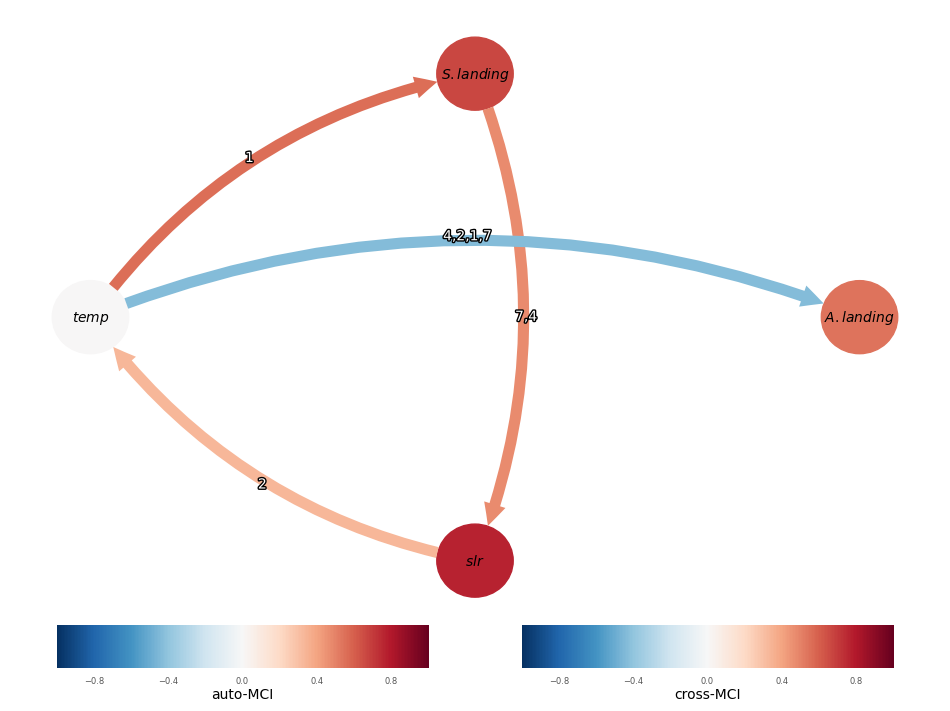

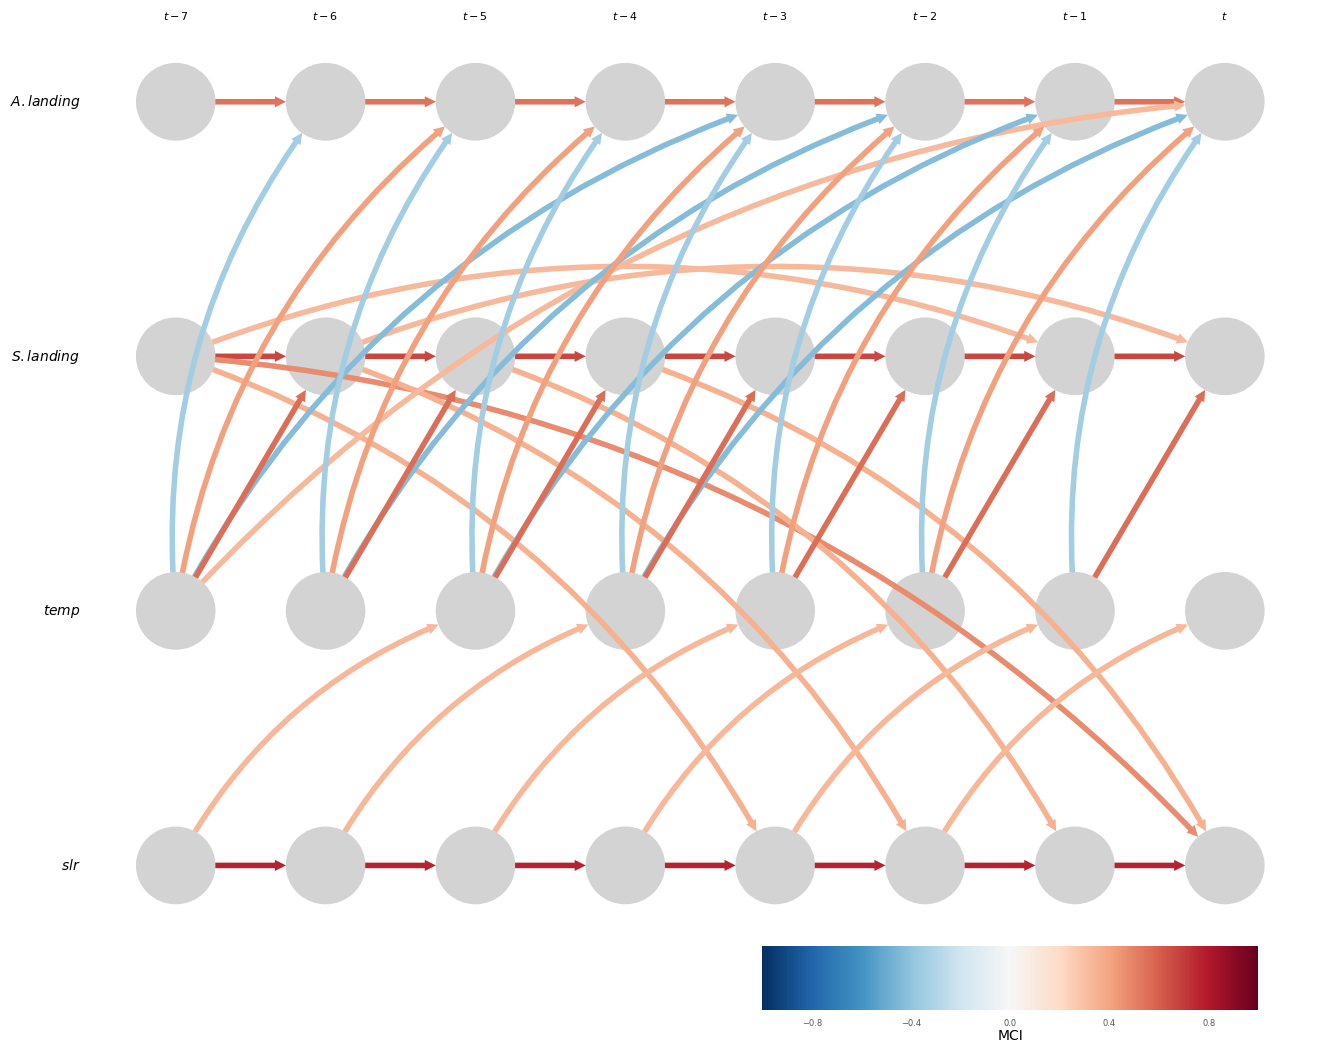

In [20]:
pcmci = Run_PCMCI(df_result1)

link_matrix0 = pcmci.run_pcmci(tau_max=7, alpha_level=0.05, pc_alpha=[0.01,0.05,0.1,0.2,0.3,0.4,0.5])
# Plot casual network
tp.plot_graph( 
    figsize=(12,8),
    graph=link_matrix0.get("graph"),
    val_matrix=link_matrix0['val_matrix'],
    var_names=var_names,
    link_colorbar_label='cross-MCI',
    node_colorbar_label='auto-MCI',
    ); plt.show()

# Plot time series graph    
tp.plot_time_series_graph(
    graph=link_matrix0.get("graph"),
    figsize=(16, 12),
    val_matrix=link_matrix0['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    ); plt.show()

In [21]:
a = ALL_MCI(pcmci, 7)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 7
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 5 link(s):
    [pc_alpha = 0.4]
        ($A.landing$ -1): max_pval = 0.00011, min_val =  0.520
        ($temp$ -2): max_pval = 0.18554, min_val =  0.188
        ($temp$ -4): max_pval = 0.28299, min_val = -0.153
        ($A.landing$ -2): max_pval = 0.31122, min_val =  0.148
        ($S.landing$ -7): max_pval = 0.39661, min_val =  0.124

    Variable $S.landing$ has 7 link(s):
    [pc_alpha = 0.4]
        ($S.landing$ -1): max_pval = 0.00000, min_val =  0.779
        ($S.landing$ -7): max_pval = 0.01439, min_val = -0.359
        ($A.landing$ -4): max_pval = 0.19103, min_val = -0.196
        ($S.landing$ -6): max_pval = 0.26093, min_val =  0.167
        ($A.landing$ -5): max_pval = 0.28926, min_val =

In [25]:
import csv

for i in range(0, number):
    
    net = Run_PCMCI(all_clips[i])
    matrix = ALL_MCI(net, 7)
    with open('Humboldt_mci_all.csv', "a", newline = "") as s:
        w = csv.writer(s)
        for variable in matrix:
            w.writerow(variable)
        w.writerow('\n')


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 7
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 3 link(s):
    [pc_alpha = 0.6]
        ($S.landing$ -6): max_pval = 0.55058, min_val =  0.649
        ($temp$ -6): max_pval = 0.30557, min_val = -0.580
        ($A.landing$ -2): max_pval = 0.53960, min_val = -0.370

    Variable $S.landing$ has 2 link(s):
    [pc_alpha = 0.2]
        ($slr$ -6): max_pval = 0.14248, min_val = -0.752
        ($A.landing$ -4): max_pval = 0.08682, min_val =  0.749

    Variable $temp$ has 3 link(s):
    [pc_alpha = 0.4]
        ($A.landing$ -5): max_pval = 0.12570, min_val =  0.773
        ($S.landing$ -5): max_pval = 0.24883, min_val =  0.636
        ($A.landing$ -3): max_pval = 0.31687, min_val =  0.496

    Variable $slr$ has 4 link(s):
    [pc_alpha = 0.4]
 


## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 3 link(s):
    [pc_alpha = 0.6]
        ($temp$ -2): max_pval = 0.45321, min_val =  0.757
        ($S.landing$ -5): max_pval = 0.52577, min_val =  0.678
        ($temp$ -5): max_pval = 0.59093, min_val =  0.599

    Variable $S.landing$ has 3 link(s):
    [pc_alpha = 0.5]
        ($A.landing$ -1): max_pval = 0.41460, min_val =  0.795
        ($temp$ -5): max_pval = 0.30301, min_val = -0.582
        ($temp$ -2): max_pval = 0.49916, min_val =  0.348

    Variable $temp$ has 4 link(s):
    [pc_alpha = 0.5]
        ($temp$ -2): max_pval = 0.38236, min_val = -0.508
        ($A.landing$ -7): max_pval = 0.43721, min_val = -0.773
        ($slr$ -1): max_pval = 0.38964, min_val =  0.434
        ($slr$ -4): max_pval = 0.40260, min_val = -0.424

    Variable $slr$ has 4 link(s):
    [pc_alpha = 0.4]
        ($S.landing$ -4): max_pval = 0.20362, min_val = -0.949
        ($temp$ -5): max_pval = 0.32884, min_val = -0.870
        